In [1]:
import json 
import matplotlib
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import sklearn 
import statistics
import seaborn as sns
%matplotlib inline


In [2]:
from numpy import *
from matplotlib.pyplot import *

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.bf'] = 'DejaVu Sans:italic:bold'


In [3]:
full_data = pd.read_csv('../../data/raw-data/filtered_everything.csv', index_col=0)
combined_test = pd.read_csv('../../data/splitted-data/everything/nbins-10/test_set.csv', index_col=0)
m2575 = pd.read_csv('../../data/raw-data/unprocessed/mixed-25-75.csv', index_col=0)
m2575_test = pd.read_csv('../../data/splitted-data/mixed2575/nbins-10/test_set.csv', index_col=0)
m5050_test = pd.read_csv('../../data/splitted-data/mixed5050/nbins-10/test_set.csv', index_col=0)

In [4]:
oresults_path = '../predicted-results/original/nbins-10'
mresults_path = '../predicted-results/mixed5050/nbins-10'
eresults_path = '../predicted-results/everything/nbins-10'

omodels_path = '../models/original'
mmodels_path = '../models/mixed5050/nbins-10'
emodels_path = '../models/everything/nbins-10'

test_sets = ['5050', '2575', 'everything']

mpoints = [100, 200, 300, 500, 1000, 2000, 2500, 'all']
epoints = [100, 200, 300, 500, 1000, 2000, 2500, 4000, 6000, 'all']


In [5]:
# Consider 5050 models and everything models at the 2500 mark 
m5models = dict()
emodels = dict()
omodels = dict()
# 5050 model
for tset in ['5050', '2575', 'everything']:
    m5models[tset] = dict()
    emodels[tset] = dict()
    omodels[tset] = dict()
    
    '''First load the original models'''
    for target in ['COF', 'intercept']:
        with open(f'{omodels_path}/{target}.pickle', 'rb') as f:
            model = pickle.load(f)
        with open(f'{omodels_path}/{target}.pickle', 'rb') as f:
            features = pickle.load(f)
        with open(f'{oresults_path}/{target}_on_{tset}.json', 'r') as f:
            data = json.load(f)
        omodels[tset][target] = {
                                 #'model': model,
                                 'features': features,
                                 'data': data,
                                 'n_train': len(model.oob_prediction_),
                                 'r_square': data[target]['r_square']}
        
    '''Then load the mixed5050 models'''
    for point in mpoints:
        for i in range(5):
            for target in ['COF', 'intercept']:
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{mresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    if not m5models[tset].get(target):
                        m5models[tset][target] = dict()
                    m5models[tset][target][point] = {
                      #'model': model,
                      'features': features,
                      'data': [data],
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    m5models[tset][target][point]['data'].append(data)
                    m5models[tset][target][point]['r_square'].append(data[target]['r_square'])
                    
    '''Finally load the combined models'''
    for point in epoints:
        # Lastly deal with the everything models
        for i in range(5):
            for target in ['COF', 'intercept']:
                with open(f'{emodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{emodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{eresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    if not emodels[tset].get(target):
                        emodels[tset][target] = dict()
                    emodels[tset][target][point] = {
                      #'model': model,
                      'features': features,
                      'data': [data],
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    emodels[tset][target][point]['data'].append(data)
                    emodels[tset][target][point]['r_square'].append(data[target]['r_square'])


In [6]:
for tset in ['5050', '2575', 'everything']:
    for point in mpoints:
        for target in ['COF', 'intercept']:
            m5models[tset][target][point]['ave_data'] = dict() 
            m5models[tset][target][point]['std_data'] = dict()
            m5models[tset][target][point]['ratio-to-simulated'] = dict()
            m5models[tset][target][point]['error'] = dict()
            for j in m5models[tset][target][point]['data'][0][target]:
                for i in range(5):
                    if i==0 and j!='r_square':
                        m5models[tset][target][point]['ave_data'][j] = [m5models[tset][target][point]['data'][i][target][j][f'predicted-{target}']]
                    elif j!='r_square':
                        m5models[tset][target][point]['ave_data'][j].append(m5models[tset][target][point]['data'][i][target][j][f'predicted-{target}'])
                if j!='r_square':
                    m5models[tset][target][point]['std_data'][j] = statistics.stdev(m5models[tset][target][point]['ave_data'][j])
                    m5models[tset][target][point]['ave_data'][j] = statistics.mean(m5models[tset][target][point]['ave_data'][j])
                    m5models[tset][target][point]['ratio-to-simulated'][j] = m5models[tset][target][point]['ave_data'][j]/m5models[tset][target][point]['data'][i][target][j][f'simulated-{target}']
                    m5models[tset][target][point]['error'][j] = m5models[tset][target][point]['ave_data'][j] - m5models[tset][target][point]['data'][i][target][j][f'simulated-{target}']
    for point in epoints:
        for target in ['COF', 'intercept']:
            emodels[tset][target][point]['ave_data'] = dict()
            emodels[tset][target][point]['std_data'] = dict()
            emodels[tset][target][point]['ratio-to-simulated'] = dict()
            emodels[tset][target][point]['error'] = dict()
            for j in emodels[tset][target][point]['data'][0][target]:
                for i in range(5):
                    if i==0 and j!='r_square':
                        emodels[tset][target][point]['ave_data'][j] = [emodels[tset][target][point]['data'][i][target][str(j)][f'predicted-{target}']]
                    elif j!='r_square':
                        emodels[tset][target][point]['ave_data'][j].append(emodels[tset][target][point]['data'][i][target][str(j)][f'predicted-{target}'])
                if j!='r_square':
                    emodels[tset][target][point]['std_data'][j] = statistics.stdev(emodels[tset][target][point]['ave_data'][j])
                    emodels[tset][target][point]['ave_data'][j] = statistics.mean(emodels[tset][target][point]['ave_data'][j])
                    emodels[tset][target][point]['ratio-to-simulated'][j] = emodels[tset][target][point]['ave_data'][j]/emodels[tset][target][point]['data'][i][target][j][f'simulated-{target}']
                    emodels[tset][target][point]['error'][j] = emodels[tset][target][point]['ave_data'][j] - emodels[tset][target][point]['data'][i][target][j][f'simulated-{target}']



In [7]:
doi = {'mmodels': dict(),
       'emodels': dict()}
for tset in ['5050', '2575', 'everything']:
    for point in mpoints:
        doi['mmodels'][f'm50_{point}_on_{tset}'] = dict()
        for target in ['COF', 'intercept']:
            mmoi = m5models[tset][target][point]
            mdoi = dict() 
            mdoi['terminal_group_1'] = list()
            mdoi['terminal_group_2'] = list()
            mdoi['terminal_group_3'] = list()
            mdoi['frac-1'] = list() 
            mdoi['frac-2'] = list()
            mdoi[f'ave-{target}'] = list()
            mdoi[f'simulated-{target}'] = list()
            mdoi['std'] = list()
            for i in mmoi['ave_data']:
                #mdoi['idx'].append(i)
                mdoi['terminal_group_1'].append(mmoi['data'][0][target][i]['tg-1'])
                mdoi['terminal_group_2'].append(mmoi['data'][0][target][i]['tg-2'])
                mdoi['terminal_group_3'].append(mmoi['data'][0][target][i]['tg-3'])
                mdoi['frac-1'].append(mmoi['data'][0][target][i]['frac-1'])
                mdoi['frac-2'].append(mmoi['data'][0][target][i]['frac-2'])
                mdoi[f'ave-{target}'].append(mmoi['ave_data'][i])
                mdoi[f'simulated-{target}'].append(mmoi['data'][0][target][i][f'simulated-{target}'])
                mdoi[f'std'].append(mmoi['std_data'][i])
                                    
                doi['mmodels'][f'm50_{point}_on_{tset}'][target] = pd.DataFrame.from_dict(mdoi)
                
    for point in epoints:
        doi['emodels'][f'eve_{point}_on_{tset}'] = dict()            
        for target in ['COF', 'intercept']:
            emoi = emodels[tset][target][point]
            edoi = dict() 
            edoi['terminal_group_1'] = list()
            edoi['terminal_group_2'] = list()
            edoi['terminal_group_3'] = list()
            edoi['frac-1'] = list() 
            edoi['frac-2'] = list()
            edoi[f'ave-{target}'] = list()
            edoi[f'simulated-{target}'] = list()
            edoi['std'] = list()
            for i in emoi['ave_data']:
                #mdoi['idx'].append(i)
                edoi['terminal_group_1'].append(emoi['data'][0][target][i]['tg-1'])
                edoi['terminal_group_2'].append(emoi['data'][0][target][i]['tg-2'])
                edoi['terminal_group_3'].append(emoi['data'][0][target][i]['tg-3'])
                edoi['frac-1'].append(emoi['data'][0][target][i]['frac-1'])
                edoi['frac-2'].append(emoi['data'][0][target][i]['frac-2'])
                edoi[f'ave-{target}'].append(emoi['ave_data'][i])
                edoi[f'simulated-{target}'].append(emoi['data'][0][target][i][f'simulated-{target}'])
                edoi[f'std'].append(emoi['std_data'][i])
            
                doi['emodels'][f'eve_{point}_on_{tset}'][target] = pd.DataFrame.from_dict(edoi)
                
                

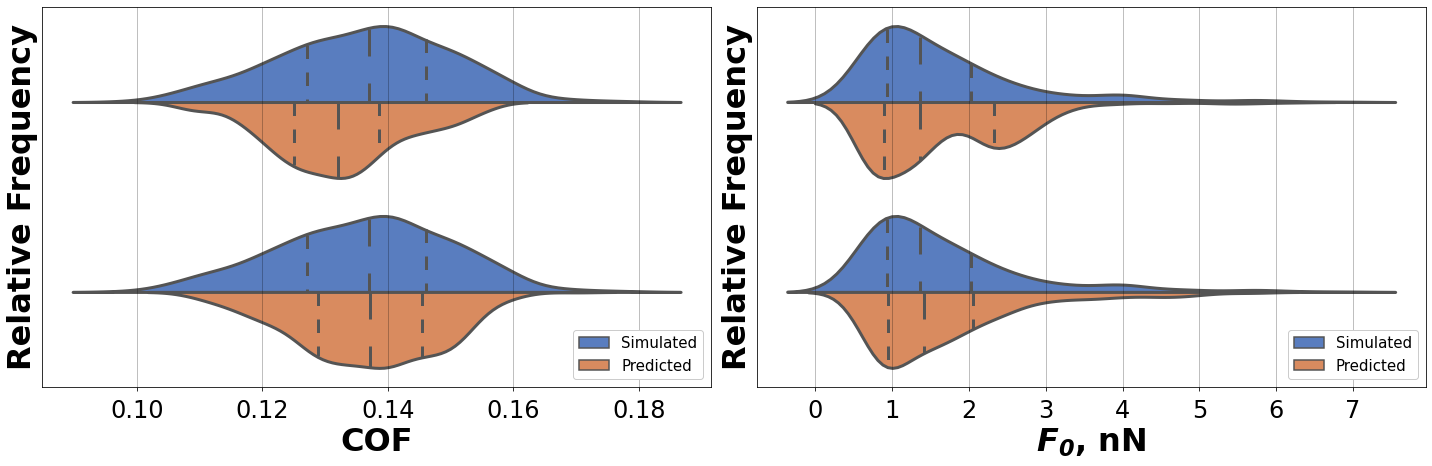

In [8]:
m5050_test_m1000 = m5050_test.copy()
m5050_test_o100 = m5050_test.copy()

m2575_test_tmp = m2575_test.copy()
mmodels_COF_1000_on_5050_tmp = doi['mmodels']['m50_1000_on_5050']['COF'].copy().rename(columns={'ave-COF': 'COF'})
mmodels_COF_1000_on_2575_tmp = doi['mmodels']['m50_1000_on_2575']['COF'].copy().rename(columns={'ave-COF': 'COF'})
mmodels_F0_1000_on_5050_tmp = doi['mmodels']['m50_1000_on_5050']['intercept'].copy().rename(columns={'ave-intercept': 'intercept'})
mmodels_F0_1000_on_2575_tmp = doi['mmodels']['m50_1000_on_2575']['intercept'].copy().rename(columns={'ave-intercept': 'intercept'})
omodels_COF_100_on_5050_tmp = pd.DataFrame.from_dict(omodels['5050']['COF']['data']['COF']).drop(columns=['r_square']).T.rename(columns={'predicted-COF': 'COF',
                                                                                                                                         'tg-1': 'terminal_group_1',
                                                                                                                                         'tg-2': 'terminal_group_2',
                                                                                                                                         'tg-3': 'terminal_group_3'})
omodels_F0_100_on_5050_tmp = pd.DataFrame.from_dict(omodels['5050']['intercept']['data']['intercept']).drop(columns=['r_square']).T.rename(columns={'predicted-intercept': 'intercept',
                                                                                                                                                    'tg-1': 'terminal_group_1',
                                                                                                                                                    'tg-2': 'terminal_group_2',
                                                                                                                                                    'tg-3': 'terminal_group_3'})
omodels_COF_100_on_5050_tmp['COF'] = omodels_COF_100_on_5050_tmp['COF'].astype('float64')
omodels_F0_100_on_5050_tmp['intercept'] = omodels_F0_100_on_5050_tmp['intercept'].astype('float64')

m5050_test_m1000.insert(0, 'set', 'M1000')
m5050_test_o100.insert(0, 'set', 'O100')
m2575_test_tmp.insert(0, 'set', 'M1000')
mmodels_COF_1000_on_5050_tmp.insert(0, 'set', 'M1000')
mmodels_COF_1000_on_2575_tmp.insert(0, 'set', 'M1000') 
mmodels_F0_1000_on_5050_tmp.insert(0, 'set', 'M1000') 
mmodels_F0_1000_on_2575_tmp.insert(0, 'set', 'M1000') 
omodels_COF_100_on_5050_tmp.insert(0, 'set', 'O100')
omodels_F0_100_on_5050_tmp.insert(0, 'set', 'O100')

m5050_test_m1000.insert(0, 'mode', 'Simulated')
m5050_test_o100.insert(0, 'mode', 'Simulated')

m2575_test_tmp.insert(0, 'mode', 'Simulated')
mmodels_COF_1000_on_5050_tmp.insert(0, 'mode', 'Predicted')
mmodels_COF_1000_on_2575_tmp.insert(0, 'mode', 'Predicted') 
mmodels_F0_1000_on_5050_tmp.insert(0, 'mode', 'Predicted') 
mmodels_F0_1000_on_2575_tmp.insert(0, 'mode', 'Predicted') 
omodels_COF_100_on_5050_tmp.insert(0, 'mode', 'Predicted')
omodels_F0_100_on_5050_tmp.insert(0, 'mode', 'Predicted')

COF_df = pd.concat([
                    m5050_test_o100,
                    m5050_test_m1000,
                    mmodels_COF_1000_on_5050_tmp,
                    omodels_COF_100_on_5050_tmp],
                   ignore_index=True)
F0_df = pd.concat([ 
                   m5050_test_o100,
                   m5050_test_m1000,
                   omodels_F0_100_on_5050_tmp,
                   mmodels_F0_1000_on_5050_tmp],
                   ignore_index=True)
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
sns.violinplot(x='COF', y='set', data=COF_df, color="0.8", scale='count', hue='mode',
               split=True, palette='muted', inner="quart")
plt.ylabel('Relative Frequency')
plt.yticks([], color='None')
plt.legend(loc=4)

plt.subplot(2, 2, 2)
sns.violinplot(x='intercept', y='set', data=F0_df, color="0.8", scale='count', hue='mode',
               split=True, palette='muted', inner="quart")
plt.ylabel('Relative Frequency')
plt.xlabel(r'$\mathbf{F_0}$, nN')
plt.yticks([], color='None')
plt.legend(loc=4)

plt.savefig('./plots/violin/m1000o100_on_t5050.pdf', bbox_inches='tight')